# Portfolio Optimization using DEAP

In [9]:
import numpy as np
import yfinance as yf
import random
from deap import creator, base, tools
import matplotlib.pyplot as plt

In [10]:
# Define the list of stocks and fetch historical data
fintech_stocks = ['V', 'MA', 'PYPL', 'SQ', 'ADP', 'GS', 'MS', 'JPM']
start_date = '2020-01-01'
end_date = '2023-01-01'

In [11]:
# Function to fetch adjusted close prices
def fetch_data(symbols, start, end):
    return yf.download(symbols, start=start, end=end)['Adj Close']

In [12]:
# Function to evaluate portfolio based on expected return
def evaluate_portfolio(weights, returns):
    weights = np.array(weights)  # Convert to NumPy array
    return np.sum(returns.mean() * weights) * 252,  # Annualized return

In [13]:
# DEAP setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize fitness
creator.create("Individual", list, fitness=creator.FitnessMax) 

toolbox = base.Toolbox()
toolbox.register("weights", np.random.dirichlet, np.ones(len(fintech_stocks)))  # Random weights
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.weights)
toolbox.register("evaluate", evaluate_portfolio, returns=None)  # No returns yet

C:\Users\mgs\AppData\Roaming\Python\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\mgs\AppData\Roaming\Python\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [14]:
# Fetch data and calculate returns
data = fetch_data(fintech_stocks, start_date, end_date)
returns = data.pct_change().dropna()  # Daily returns
toolbox.register("evaluate", evaluate_portfolio, returns=returns)  # Register evaluation with returns

[*********************100%%**********************]  8 of 8 completed


In [15]:
# Main optimization process
def main():
    population = tools.initRepeat(list, toolbox.individual, n=100)  # Create initial population
    NGEN = 50  # Number of generations
    best_fitnesses = []  # List to store best fitness values

    for gen in range(NGEN):
        # Evaluate the individuals
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit  # Assign fitness values

        # Select the next generation individuals
        offspring = tools.selTournament(population, len(population), tournsize=3)

        # Apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:  # Crossover chance
                tools.cxBlend(child1, child2, alpha=0.5)
                del child1.fitness.values  # Clear fitness for re-evaluation
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:  # Mutation chance
                tools.mutGaussian(mutant, mu=0, sigma=0.1, indpb=0.2)
                del mutant.fitness.values

        # Replace the old population with the offspring
        population[:] = offspring

        # Store the best fitness value of the current generation only from evaluated individuals
        evaluated_individuals = [ind for ind in population if ind.fitness.valid]
        if evaluated_individuals:  # Ensure there are evaluated individuals
            best_fitness = max(ind.fitness.values[0] for ind in evaluated_individuals)
            best_fitnesses.append(best_fitness)
            print(f"Generation {gen}: Best fitness = {best_fitness}")

    # Return the best portfolio found
    best_portfolio = tools.selBest(population, 1)[0]
    print("Best portfolio weights:", best_portfolio)

    # Plotting the best fitness values over generations
    plt.plot(best_fitnesses)
    plt.title("Best Fitness Over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness (Expected Return)")
    plt.grid()
    plt.show()

    return best_portfolio


Generation 0: Best fitness = 0.2133592991020646
Generation 1: Best fitness = 0.1934781335498923
Generation 4: Best fitness = 0.28061123049014236
Generation 5: Best fitness = 0.13843722802940708
Best portfolio weights: [2.228792674355055, -0.23144887845973236, 4.955647335936181, 2.3891162543393865, 2.8847665309452863, 0.2135080239997693, -0.020405004370713353, 1.0984156870570165]


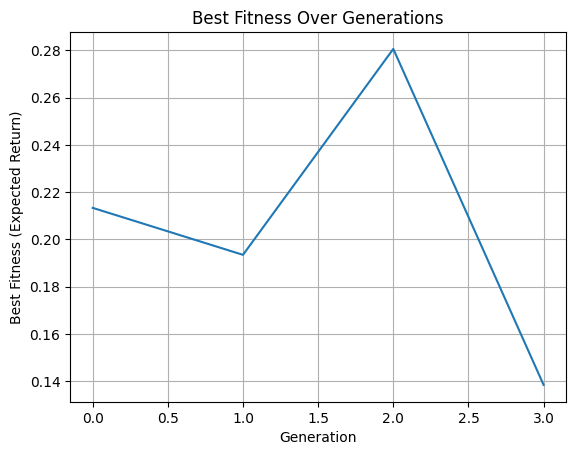

In [16]:

if __name__ == "__main__":
    best_portfolio = main()

### Explanation:

# Data Fetching**: The script fetches historical stock price data for the specified fintech stocks using the `yfinance` library.
# Fitness Evaluation**: The fitness function calculates the expected return and risk (standard deviation) of the portfolio. The goal is to maximize the return while minimizing risk.
# DEAP Setup**: The DEAP framework is set up to create individuals (portfolios) with random weights that sum to 1. The fitness function is registered along with selection, crossover, and mutation methods.
# Optimization Loop**: The main function runs the genetic algorithm for a specified number of generations, selecting and breeding new portfolios while maintaining diversity through mutation.
# Output**: At the end of the optimization, the best portfolio weights are printed.

